# Zadanie II: Strażnik Cyberbezpieczeństwa – Ochrona Systemu
W tym zadaniu analizuję logi serwera w celu wykrycia potencjalnych ataków hakerskich. Celem jest stworzenie modelu detekcji anomalii, który pozwoli na identyfikację nietypowych zachowań w systemie. W pierwszej kolejności przeprowadzę eksplorację danych, aby zbadać potencjalne cechy i wyczuć co będzie wazne podczas projektowania i trenowania modeli statystycznych jak i sieci neuronowych.

## Plan działania
1. Eksploracja danych
2. Feature engineering, preprocessing, etc...
2. Opracowanie modelu statystycznego
3. Opracowanie sieci neuronowej
4. Trenowanie oraz walidacja sieci neuronowej
5. Test skuteczności na datasecie testowym

# 1. Eksploracja danych
Zacznę od przejrzenia z jakimi danymi mam doczynienia

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from collections import Counter
import ipaddress
import re
from urllib.parse import parse_qs, urlparse

# Set style for better visualizations
plt.style.use('seaborn-v0_8-dark')
sns.set_palette("husl")

# Read the CSV file
df = pd.read_csv('data/logs.csv', header=None, 
                 names=['date', 'time', 'ip', 'method', 'path', 'protocol', 
                        'status', 'referrer', 'user_agent', 'payload']
                 )

# Combine date and time into a datetime column
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], 
                               format='%d/%b/%Y %H:%M:%S')

# Basic info about the dataset
print("Dataset Info:")
print(df.info())
print("\nSample of the data:")
print(df.head())
print("\nTail of the data:")
print(df.tail(1))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14945 entries, 0 to 14944
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        14945 non-null  object        
 1   time        14945 non-null  object        
 2   ip          14945 non-null  object        
 3   method      14945 non-null  object        
 4   path        14945 non-null  object        
 5   protocol    14945 non-null  object        
 6   status      14945 non-null  int64         
 7   referrer    11677 non-null  object        
 8   user_agent  14945 non-null  object        
 9   payload     5128 non-null   object        
 10  timestamp   14945 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 1.3+ MB
None

Sample of the data:
          date      time             ip method        path  protocol  status  \
0  06/Jan/2025  06:02:58  82.81.156.133    GET           /  HTTP/1.1     200  

## Charakterystyka danych
Mamy doczynienia z zrzutem 14945 logów sieciowych serwera `kingbank.pl` na przełomie 10 dni. Jest to niewielka liczba danych. Jak na logi aplikacji są całkiem nieźle ustruktyryzowane i zostały juz prawdopodbnie początkowo wyabstraktowane. 

1. Ruch sieciowy składa się jedynie z ruchu HTTP
2. Są to logi poszczególnych punktów końcowych API

In [10]:
# count unique values for each column
print("\nUnique values for each column:")
print(df.nunique())


Unique values for each column:
date             11
time          10002
ip             2194
method            2
path           1004
protocol          1
status            5
referrer        958
user_agent       30
payload        3014
timestamp     10869
dtype: int64


### Dzięki liście unikalnych wartości widzimy: 
- większość wartości dla payload jest unikalna (3014/5128). 
- Protokół jest tylko jeden: HTTP, nie istotny jako cecha dla modeli. 
- Wyjątkowo mało jest unikalnych user_agent. (mozliwe ze bottom user-agent pokaze coś ciekawego)
- Unikalnych IP jest ~1/7 (2194/14945) zbioru danych. Sugeruje, ze sesje nie trwały długo
- Ciekawe jest, ze unikalnych znaczników czasowych jest tylko 2/3 zbioru danych, mozliwe ataki siłowe

## Przydatne statystyki danych

/var/folders/v2/1kxhdlt556vd788lhq7q84xm0000gn/T/ipykernel_81822/4263959791.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.set_index('timestamp').resample('1H')['method'].count().plot()


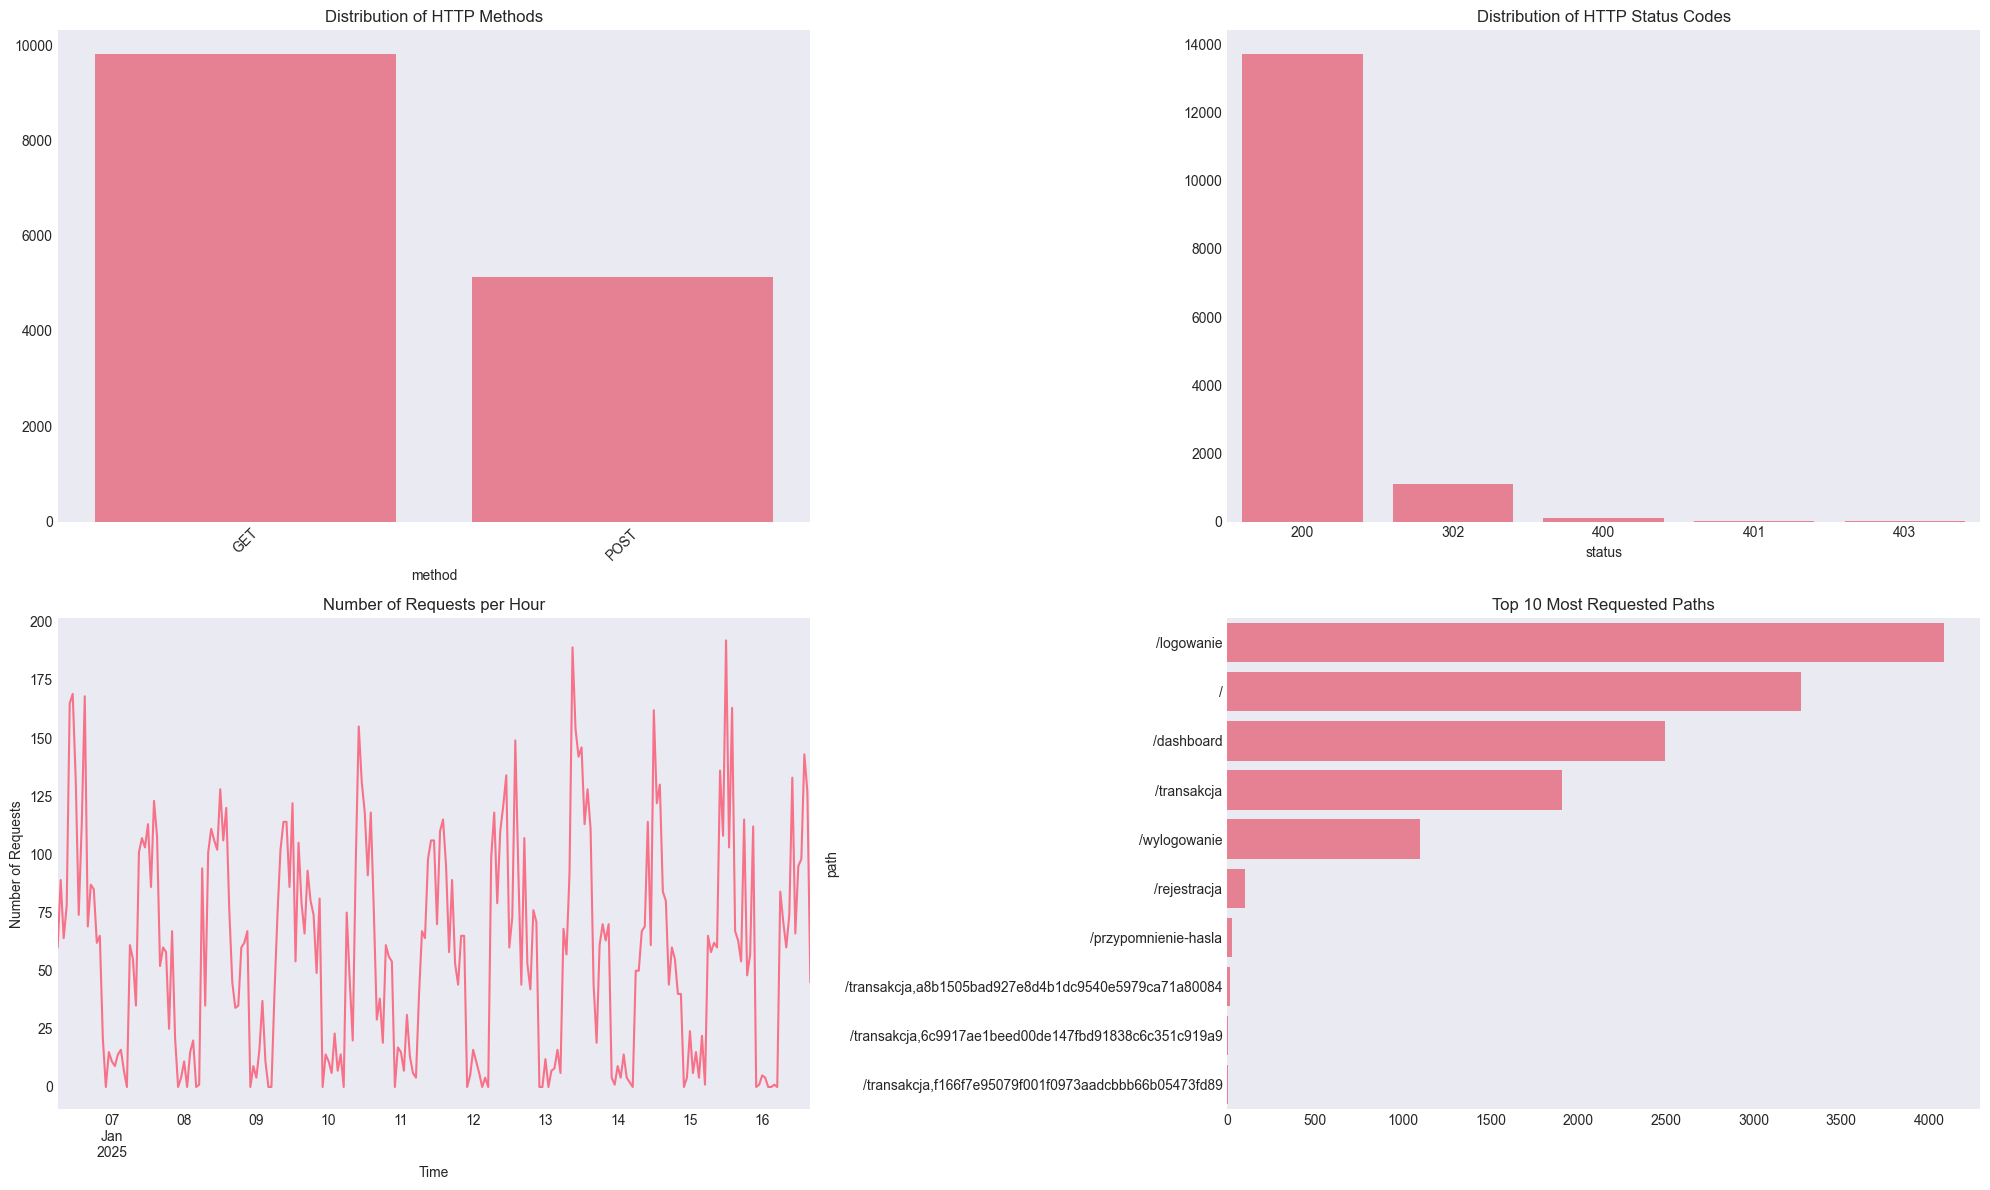


Top 10 IP addresses by number of requests:
ip
185.152.64.228    22
83.9.37.128       18
81.76.152.106     15
81.244.34.85      12
81.109.23.243     11
82.138.15.187     11
185.85.192.179    11
82.224.11.152     11
82.234.206.15     11
81.212.45.173     11
Name: count, dtype: int64

Top 10 paths with their request counts:
path
/logowanie                                              4087
/                                                       3268
/dashboard                                              2498
/transakcja                                             1906
/wylogowanie                                            1100
/rejestracja                                             100
/przypomnienie-hasla                                      24
/transakcja,a8b1505bad927e8d4b1dc9540e5979ca71a80084      15
/transakcja,6c9917ae1beed00de147fbd91838c6c351c919a9       2
/transakcja,f166f7e95079f001f0973aadcbbb66b05473fd89       2
Name: count, dtype: int64


In [12]:
# Create a figure with multiple subplots
plt.figure(figsize=(20, 12))

# 1. Request Methods Distribution
plt.subplot(2, 2, 1)
method_counts = df['method'].value_counts()
sns.barplot(x=method_counts.index, y=method_counts.values)
plt.title('Distribution of HTTP Methods')
plt.xticks(rotation=45)

# 2. Status Codes Distribution
plt.subplot(2, 2, 2)
status_counts = df['status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title('Distribution of HTTP Status Codes')

# 3. Requests Over Time
plt.subplot(2, 2, 3)
df.set_index('timestamp').resample('1H')['method'].count().plot()
plt.title('Number of Requests per Hour')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45)

# 4. Top 10 Most Requested Paths
plt.subplot(2, 2, 4)
path_counts = df['path'].value_counts().head(10)
sns.barplot(x=path_counts.values, y=path_counts.index)
plt.title('Top 10 Most Requested Paths')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTop 10 IP addresses by number of requests:")
print(df['ip'].value_counts().head(10))

print("\nTop 10 paths with their request counts:")
print(df['path'].value_counts().head(10))

### Wnioski na temat powyzszych statystyk danych 
Jak widać nie ma zadnego adresu IP, k†óry miałby nienaturalnie duzą liczbę zapytań. 

Natomiast na pewno punkt końcowy /logowanie ma nienaturalnie duzą liczbę uderzeń, większą niz strona główna aplikacji, jest to ewidentnie nienaturalne zachowanie i potencjalny atak. Zobaczmy dokładniej  

/var/folders/v2/1kxhdlt556vd788lhq7q84xm0000gn/T/ipykernel_81822/3302055596.py:69: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  login_attempts.set_index('timestamp')['ip'].resample('1H').count().plot()


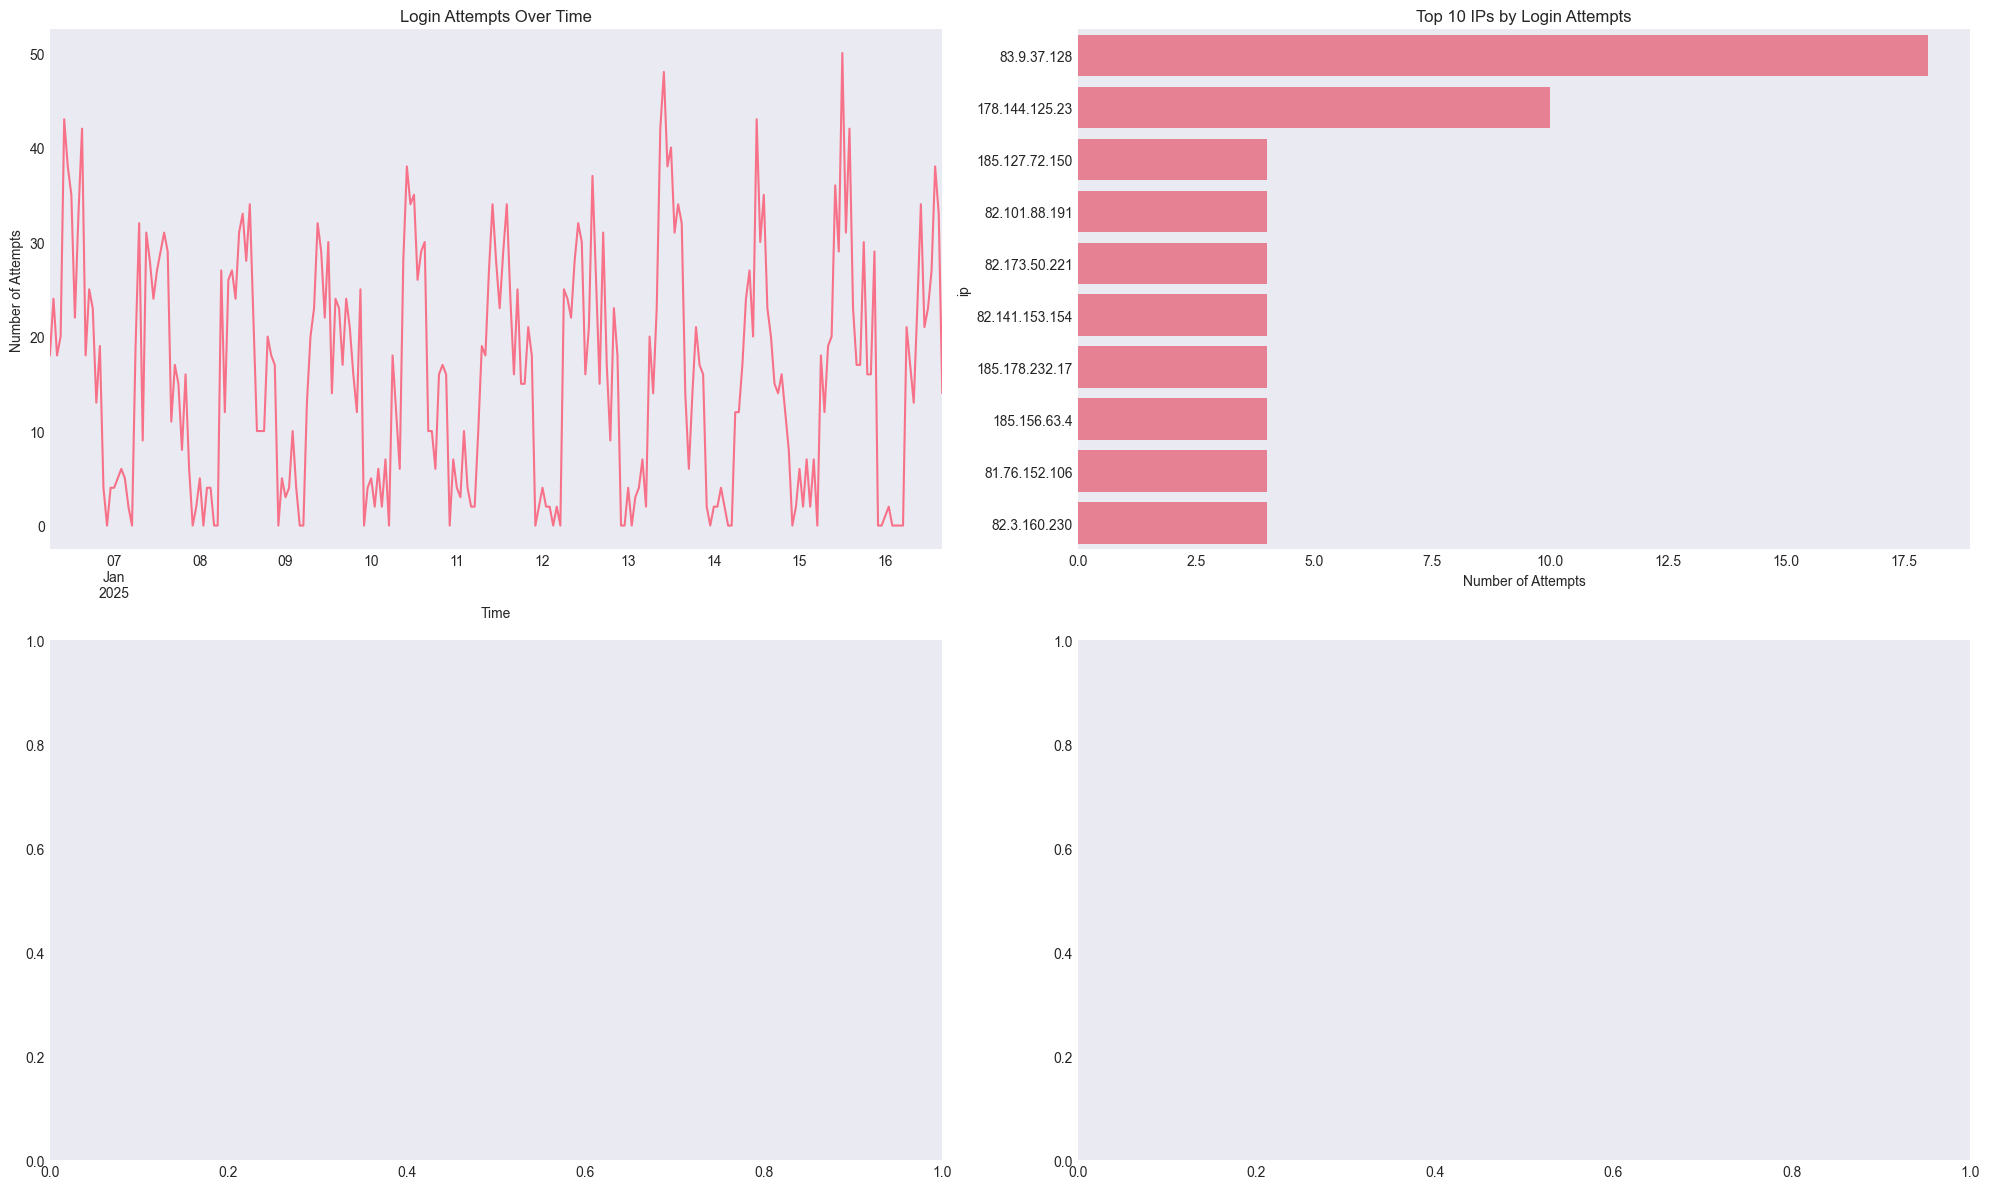


Security Analysis Summary:
Total number of login attempts: 4087
Number of unique IPs making login attempts: 2023
Number of rapid request incidents: 1
Number of suspicious payloads detected: 3
Number of unusual paths accessed: 0

Sequential Login Attempts Analysis:
IP: 178.144.125.23
Total login attempts: 10
Timespan: 0 days 00:00:57
--------------------------------------------------
IP: 83.9.37.128
Total login attempts: 18
Timespan: 0 days 00:01:03
--------------------------------------------------

Path patterns for suspicious IPs:
Series([], Name: count, dtype: int64)


In [13]:
# Function to detect potential suspicious patterns
def analyze_suspicious_patterns(df):
    suspicious_patterns = {
        'rapid_requests': [],
        'login_attempts': [],
        'suspicious_payloads': [],
        'unusual_paths': []
    }
    
    # 1. Detect rapid requests from same IP (more than 10 requests per minute)
    ip_time_groups = df.groupby([df['ip'], 
                                df['timestamp'].dt.floor('min')])['method'].count()
    rapid_requests = ip_time_groups[ip_time_groups > 10]
    
    # 2. Analyze login attempts - specifically looking at failed login patterns
    login_attempts = df[df['path'].str.contains('/logowanie', na=False)]
    failed_logins = login_attempts[
        login_attempts['payload'].str.contains('error|failed|invalid', 
                                             na=False, case=False, regex=True)]
    
    # 3. Look for suspicious payloads - using safe pattern matching
    suspicious_patterns = [
        r'script\W*', r'eval\s*\(', r'exec\s*\(', r'SELECT\s+\w+', 
        r'UNION\s+SELECT', r'DROP\s+TABLE', r'alert\s*\(', 
        r'<[^>]*script'
    ]
    pattern = '|'.join(suspicious_patterns)
    suspicious_payloads = df[
        df['payload'].str.contains(pattern, na=False, case=False, regex=True)]
    
    # 4. Detect unusual paths
    unusual_path_patterns = [
        r'\.\./', r'%00', r'/etc/passwd', r'/wp-admin',
        r'\.php$', r'\.asp$', r'\.exe$', r'\.dll$'
    ]
    pattern = '|'.join(unusual_path_patterns)
    unusual_paths = df[
        (df['path'].str.len() > 100) | 
        (df['path'].str.contains(pattern, na=False, case=False, regex=True))]
    
    # Additional analysis - Looking for sequential failed login attempts
    sequential_login_attempts = []
    for ip in df['ip'].unique():
        ip_logins = login_attempts[login_attempts['ip'] == ip]
        if len(ip_logins) > 5:  # More than 5 login attempts from same IP
            sequential_login_attempts.append({
                'ip': ip,
                'count': len(ip_logins),
                'timespan': ip_logins['timestamp'].max() - ip_logins['timestamp'].min()
            })
    
    return {
        'rapid_requests': rapid_requests,
        'login_attempts': failed_logins,
        'suspicious_payloads': suspicious_payloads,
        'unusual_paths': unusual_paths,
        'sequential_logins': sequential_login_attempts
    }

# Analyze suspicious patterns
suspicious_patterns = analyze_suspicious_patterns(df)

# Create visualization for the analysis
plt.figure(figsize=(20, 12))

# 1. Plot login attempts over time
plt.subplot(2, 2, 1)
login_attempts = df[df['path'] == '/logowanie']
login_attempts.set_index('timestamp')['ip'].resample('1H').count().plot()
plt.title('Login Attempts Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Attempts')

# 2. Plot unique IPs making login attempts
plt.subplot(2, 2, 2)
top_login_ips = login_attempts['ip'].value_counts().head(10)
sns.barplot(x=top_login_ips.values, y=top_login_ips.index)
plt.title('Top 10 IPs by Login Attempts')
plt.xlabel('Number of Attempts')

# 3. Plot HTTP methods used in suspicious requests
plt.subplot(2, 2, 3)
suspicious_methods = df[df['ip'].isin(suspicious_patterns['rapid_requests'].index)]['method'].value_counts()
if not suspicious_methods.empty:
    sns.barplot(x=suspicious_methods.index, y=suspicious_methods.values)
    plt.title('HTTP Methods in Suspicious Requests')
    plt.xticks(rotation=45)

# 4. Plot path distribution for suspicious requests
plt.subplot(2, 2, 4)
suspicious_paths = df[df['ip'].isin(suspicious_patterns['rapid_requests'].index)]['path'].value_counts().head(10)
if not suspicious_paths.empty:
    sns.barplot(x=suspicious_paths.values, y=suspicious_paths.index)
    plt.title('Top Paths in Suspicious Requests')

plt.tight_layout()
plt.show()

# Print summary statistics and findings
print("\nSecurity Analysis Summary:")
print(f"Total number of login attempts: {len(login_attempts)}")
print(f"Number of unique IPs making login attempts: {login_attempts['ip'].nunique()}")
print(f"Number of rapid request incidents: {len(suspicious_patterns['rapid_requests'])}")
print(f"Number of suspicious payloads detected: {len(suspicious_patterns['suspicious_payloads'])}")
print(f"Number of unusual paths accessed: {len(suspicious_patterns['unusual_paths'])}")

# Print details of sequential login attempts
print("\nSequential Login Attempts Analysis:")
for attempt in suspicious_patterns['sequential_logins']:
    print(f"IP: {attempt['ip']}")
    print(f"Total login attempts: {attempt['count']}")
    print(f"Timespan: {attempt['timespan']}")
    print("-" * 50)

# Additional analysis of paths accessed by suspicious IPs
suspicious_ips = set(suspicious_patterns['rapid_requests'].index)
if suspicious_ips:
    print("\nPath patterns for suspicious IPs:")
    suspicious_ip_paths = df[df['ip'].isin(suspicious_ips)]['path'].value_counts()
    print(suspicious_ip_paths.head(10))